In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import gc
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv('data.csv', sep=';')
etl = pd.read_csv('etalon.csv', sep=';')

In [4]:
df1 = df[df.fulldate<'2018-09-15']
df2 = df[df.fulldate>'2018-09-15']

In [5]:
print(df.shape)
df.head()

(9153692, 5)


,lac,cid,ts,fulldate,hash_id
0,7755,35950,1.536391e+09,2018-09-13,1361396
1,7755,35950,1.536391e+09,2018-09-14,1361396
2,7752,19203,1.535967e+09,2018-09-04,1361396
3,7755,35950,1.536391e+09,2018-09-09,1361396
4,7752,19203,1.535967e+09,2018-09-05,1361396


In [6]:
print(etl.shape)
etl.head()

(491, 2)


,id1,id2
0,1361396,2695335
1,1795864,2458905
2,1543059,2730453
3,1028066,2539971
4,1533076,2712514


In [7]:
#statistics of intersections for 'hash1'
def naive_intersections(lacs_a, cids_a, df, alpha=3.0):
    intersections_df = pd.DataFrame(
        columns=["hash_id", "lac_coef", "cid_coef", "wsum"]
    )

    # better to rewrite via groupby
    hash_ids = df.hash_id.unique()
    i = 0
    for hash_id in hash_ids:
        lacs_b = set(df[df.hash_id == hash_id].lac.unique())
        cids_b = set(df[df.hash_id == hash_id].cid.unique())

        tmp1 = len(lacs_a.intersection(lacs_b))
        tmp2 = len(cids_a.intersection(cids_b))
        sum1 = len(lacs_a) + len(lacs_b)
        sum2 = len(cids_a) + len(cids_b)
        lac_coef = tmp1 / sum1
        sid_coef = tmp2 / sum2

        intersections_df.loc[i] = [
            hash_id,
            lac_coef,
            sid_coef,
            lac_coef + alpha * sid_coef
        ]
        i += 1

    return intersections_df

In [10]:
%%time
#check for the first hash_id from etalon.csv
hash_id = 1361396 #id2 should be 2695335
lacs_a = set(df[df.hash_id==hash_id].lac.unique())
cids_a = set(df[df.hash_id==hash_id].cid.unique())
res = naive_intersections(lacs_a, cids_a, df2).sort_values('wsum', ascending=False).reset_index(drop=True)

CPU times: user 30.8 s, sys: 18.2 ms, total: 30.9 s
Wall time: 30.9 s


In [9]:
res.head()

,index,hash_id,lac_coef,cid_coef,wsum
0,0,2695335.0,0.250000,0.300000,1.150000
1,24,2974960.0,0.222222,0.027397,0.304414
2,2233,2091058.0,0.250000,0.010526,0.281579
3,2184,2698988.0,0.200000,0.022989,0.268966
4,2213,2473592.0,0.142857,0.040816,0.265306


# Check accuracy for 'etalon.csv' data

In [11]:
#it should not be considered as check accuracy for train data because it is supervised learning so we don't fit anything
#accuracy should be the same for 'etalon' and 'test' data

In [12]:
hash_ids1 = etl.id1.values
hash_ids2 = etl.id2.values

subdf1 = df1[df1.hash_id.isin(hash_ids1)]
subdf2 = df2[df2.hash_id.isin(hash_ids2)]

In [13]:
preds_df = etl.copy().reset_index(drop=True)

In [14]:
preds_df.head()

,id1,id2
0,1361396,2695335
1,1795864,2458905
2,1543059,2730453
3,1028066,2539971
4,1533076,2712514


In [15]:
def predict_ids(hash_ids, df1, df2, alpha=3.0):

    n = len(hash_ids)
    pred_ids = np.zeros(n)
    confidences = np.zeros(n)

    for i in range(n):
        lacs_a = set(df1[df1.hash_id == hash_ids[i]].lac.unique())
        cids_a = set(df1[df1.hash_id == hash_ids[i]].cid.unique())

        res = (
            naive_intersections(lacs_a, cids_a, df2, alpha=alpha)
            .sort_values("wsum", ascending=False)
            .reset_index()
        )
        pred_ids[i] = res.loc[0].hash_id.astype("int")
        confidences[i] = res.loc[0].wsum - res.loc[1].wsum

    return pred_ids, confidences

In [16]:
%%time
preds_df["id2_prediction"], preds_df["confidence"] = predict_ids(
    preds_df.id1.values, subdf1, subdf2
)
preds_df.id2_prediction = preds_df.id2_prediction.astype("int")

CPU times: user 14min 48s, sys: 479 ms, total: 14min 48s
Wall time: 14min 48s


In [17]:
def check_accuracy(df):
    acc = (df.id2 == df.id2_prediction).sum()
    return acc / df.shape[0]

In [18]:
check_accuracy(preds_df)
# accuracy before correction (for 491 values with known answers)
# -- it's not accuracy 'train': we have unsupervised learning so on test it should be the same result)

0.8757637474541752

In [19]:
check_accuracy(preds_df[preds_df.confidence>0.2])

0.9885057471264368

In [20]:
preds_df["correct"] = preds_df.id2 == preds_df.id2_prediction

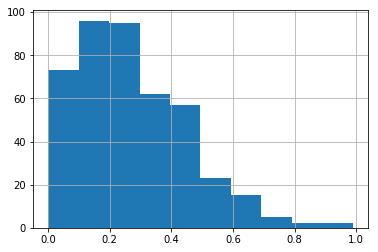

In [21]:
preds_df[preds_df.correct==True].confidence.clip(0.0, 1.0).hist();

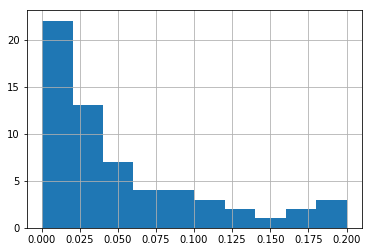

In [22]:
preds_df[preds_df.correct==False].confidence.clip(0.0, 0.2).hist();

In [23]:
confidence_threshold = 0.2
preds_df_2 = preds_df[preds_df.confidence<confidence_threshold]

In [24]:
acc = (preds_df_2.id2==preds_df_2.id2_prediction).sum()
print(acc/preds_df_2.shape[0]) #accuracy for hash_ids with low confidence of prediction

0.7478260869565218


In [25]:
%%time
#correction for low-confidence hash_ids
hash_ids_a = preds_df_2.id1.values
hash_ids_b = preds_df_2.id2.values
preds_df_2["id2_prediction_2"], preds_df_2["confidence_2"] = predict_ids(
    preds_df_2.id1.values,
    subdf1[subdf1.hash_id.isin(hash_ids_a)],
    subdf2[subdf2.hash_id.isin(hash_ids_b)],
)
preds_df_2.id2_prediction = preds_df_2.id2_prediction.astype("int")

CPU times: user 2min 49s, sys: 134 ms, total: 2min 49s
Wall time: 2min 49s


In [27]:
acc = (preds_df_2.id2==preds_df_2.id2_prediction_2).sum()
print(acc/preds_df_2.shape[0]) #accuracy after correction

0.8


In [28]:
preds_df_2['correct_2'] = (preds_df_2.id2==preds_df_2.id2_prediction_2)

In [31]:
print(len(preds_df_2[(preds_df_2.correct==False) & (preds_df_2.correct_2==True)])) #prediction became better
print(len(preds_df_2[(preds_df_2.correct==True) & (preds_df_2.correct_2==False)])) #prediction became worse

12
0


In [32]:
tp = preds_df_2[(preds_df_2.correct==False) & (preds_df_2.correct_2==True)].shape[0]
tn = preds_df_2[(preds_df_2.correct==True) & (preds_df_2.correct_2==False)].shape[0]

acc = (preds_df.id2==preds_df.id2_prediction).sum() + tp - tn
print(acc/preds_df.shape[0]) #final accuracy (for 491 values with known answers)

0.90020366598778


# Test values

In [33]:
df1_tst = df1[~df1.hash_id.isin(etl.id1)]
df2_tst = df2[~df2.hash_id.isin(etl.id2)]

In [34]:
print(len(df1_tst.hash_id.unique()))
print(len(df2_tst.hash_id.unique()))

1757
1803


In [35]:
results = pd.DataFrame(df1_tst.hash_id.unique(), columns=['id1'])

In [38]:
%%time 
# ~20s for 1 hash_id => ~10h for 1757 ids
hash_id = 1693644
lacs_a = set(df[df.hash_id==hash_id].lac.unique())
cids_a = set(df[df.hash_id==hash_id].cid.unique())
res = naive_intersections(lacs_a, cids_a, df2_tst).sort_values('wsum', ascending=False).reset_index(drop=True)

CPU times: user 19.7 s, sys: 17 ms, total: 19.7 s
Wall time: 19.7 s


In [39]:
res.head()

,hash_id,lac_coef,cid_coef,wsum
0,2788947.0,0.386364,0.238095,1.100649
1,2056723.0,0.347826,0.175066,0.873025
2,2586281.0,0.340000,0.136929,0.750788
3,2111411.0,0.327273,0.139610,0.746104
4,2264030.0,0.351852,0.130261,0.742633


In [ ]:
%%time 
#confidence>0.2 is good (it is not from [0, 1])
results['id2_prediction'], results['confidence'] = predict_ids(results.id1.values, df1_tst, df2_tst)
results.id2_prediction = results.id2_prediction.astype('int')

In [ ]:
results.to_csv('results.csv')